# Jacobian vs. Perturbation
Visualizing and Understanding Atari Agents | Sam Greydanus | 2017 | MIT License

In [1]:
from __future__ import print_function
import warnings ; warnings.filterwarnings('ignore') # mute warnings, live dangerously

import matplotlib.pyplot as plt
import matplotlib as mpl ; mpl.use("Agg")
import matplotlib.animation as manimation

import torch
from torch.autograd import Variable
import torch.nn.functional as F

import gym, os, sys, time, argparse
sys.path.append('..')
from visualize_atari import *

## Load agent, build environment, play an episode

In [2]:
env_name = 'Breakout-v0'
save_dir = 'figures/'

print("set up dir variables and environment...")
load_dir = '{}/'.format(env_name.lower())
meta = get_env_meta(env_name)
env = gym.make(env_name) ; env.seed(1)

print("initialize agent and try to load saved weights...")
model = NNPolicy(channels=1, num_actions=env.action_space.n)
_ = model.try_load(load_dir, checkpoint='*.tar') ; torch.manual_seed(1)

print("get a rollout of the policy...")
history = rollout(model, env, max_ep_len=3e3)

set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: breakout-v0/model.40.tar
get a rollout of the policy...


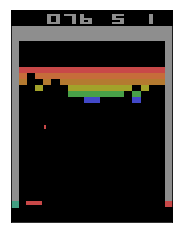

In [3]:
f = plt.figure(figsize=[3,3*1.3])
# frame_ix = 1404
frame_ix=1307
plt.imshow(history['ins'][frame_ix])
for a in f.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False)
plt.show(f)

## Get Jacobian saliency map

In [4]:
def jacobian(model, layer, top_dh, X):
    global top_h_ ; top_h_ = None
    def hook_top_h(m, i, o): global top_h_ ; top_h_ = o.clone()
    hook1 = layer.register_forward_hook(hook_top_h)
    _ = model(X) # do a forward pass so the forward hooks can be called

    # backprop positive signal
    torch.autograd.backward(top_h_, top_dh.clone(), retain_variables=True) # backward hooks are called here
    hook1.remove()
    return X[0].grad.data.clone().numpy(), X[0].data.clone().numpy()

# derivative is simply the output policy distribution
top_dh_actor = torch.Tensor(history['logits'][frame_ix]).view(1,-1)
top_dh_critic = torch.Tensor(history['values'][frame_ix]).view(1,-1).fill_(1)

# get input
tens_state = torch.Tensor(prepro(history['ins'][frame_ix]))
state = Variable(tens_state.unsqueeze(0), requires_grad=True)
hx = Variable(torch.Tensor(history['hx'][frame_ix-1]).view(1,-1))
cx = Variable(torch.Tensor(history['cx'][frame_ix-1]).view(1,-1))
X = (state, (hx, cx))

actor_jacobian, _ = jacobian(model, model.actor_linear, top_dh_actor, X)

state.grad.mul_(0) ; X = (state, (hx, cx))
critic_jacobian, _ = jacobian(model, model.critic_linear, top_dh_critic, X)

## Get perturbation saliency map

In [5]:
radius = 5
density = 5

actor_saliency = score_frame(model, history, frame_ix, radius, density, interp_func=occlude, mode='actor')
critic_saliency = score_frame(model, history, frame_ix, radius, density, interp_func=occlude, mode='critic')

In [6]:
# upsample jacobian saliencies
frame = history['ins'][frame_ix].squeeze().copy()
frame = saliency_on_atari_frame((actor_jacobian**2).squeeze(), frame, fudge_factor=1, channel=2, sigma=0)
jacobian_map = saliency_on_atari_frame((critic_jacobian**2).squeeze(), frame, fudge_factor=15, channel=0, sigma=0)

# upsample perturbation saliencies
frame = history['ins'][frame_ix].squeeze().copy()
frame = saliency_on_atari_frame(actor_saliency, frame, fudge_factor=200, channel=2)
perturbation_map = saliency_on_atari_frame(critic_saliency, frame, fudge_factor=100, channel=0)

## Plot side-by-side

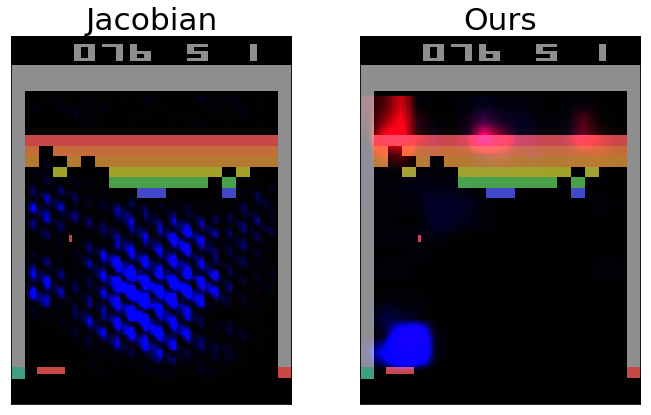

In [9]:
f = plt.figure(figsize=[11, 5*1.3], dpi=75)

plt.subplot(1,2,1)
plt.imshow(jacobian_map)
plt.title('Jacobian', fontsize=30)

plt.subplot(1,2,2)
plt.imshow(perturbation_map)
plt.title('Ours', fontsize=30)

for a in f.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False)
plt.show() #; f.savefig('./figures/jacobian-vs-perturb.png', bbox_inches='tight')